# Noise propagation in HQNSL quantum loss
In practice the circuit preparing the quantum state for which we wish to learn the symmetries of will be noisy, resulting in a state that is
not quite exactly the state we expect. Possible errors include a depolarizing error, unitary gate (e.g. Pauli), and so forth. Measurement of the quantum
loss function propagates the effect of the error classically into the metric value itself. 

A practical symmetry learning scheme must be robust, at least to some threshold, to such errors. It suffices to show that the loss function does not change significantly enough on noisy states than when the state is prepared without an `e` amount of noise. To demonstrate this, we use the generalized GHZ state. In `HQN.ipynb`, we can find some symmetries of the state both with and without noise. In this notebook, we will apply the noiseless symmetries to the noisy state and check that the quantum loss metric is still small. We will also apply the noisy symmetries to the noiseless state and check likewise that the loss is small. If both cases hold, we conclude that the learning scheme is robust to `e`-noisy states.

State preparation is not the only source of noise. The parametrized quantum circuit (PQC) that implements the symmetry operation can itself have errors similar to those in the state preparation circuit. This poses a separate robustness challenge---can the learning scheme produce valid symmetries when the circuit is itself noisy? This question requires adding a noise parameter to the PQC but does not otherwise differ in any sense to normal learning (one must simply check, as they would usually do, that the learning can converge to a negligbly small quantum loss metric.) Consequently, we defer this latter question to `HQN.ipynb`.

Everything in this notebook is classically simulated. In a quantum hardware, we (sadly) don't need to introduce error manually.

See [this link](https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html) for more.

In [3]:
from __loss_funcs import KL
from __helpers import prepare_basis, qubit_expansion
from __class_HQNet import HQNet
from __class_PQC import PQC
import numpy as np
import torch as t
from qiskit.quantum_info import Statevector
%matplotlib inline
from qiskit.providers.aer import AerSimulator
from qiskit import transpile
from qiskit.providers.aer.noise import pauli_error, depolarizing_error
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [4]:
NUM_QUBITS = 2
STATE_TYPE = 'Cluster'

PROB_DEPOL = 0.01

PROB_RESET = 0.01
PROB_MEAS = 0
PROB_GATE1 = 0.01

In [5]:
# Prepare noisy and noiseless GHZ State 
if STATE_TYPE == 'GHZ':
    from GHZ_generator import GHZ_state_circuit
    noiseless_state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS)
elif STATE_TYPE == 'Cluster':
    from cluster_generator import cluster_state_circuit
    noiseless_state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(NUM_QUBITS)
    NUM_QUBITS = NUM_QUBITS**2
else:
    raise TypeError("Invalid state type specified.")
noiseless_state = noiseless_state.evolve(qc)
qc.measure_all()
print(qc)

        ┌───┐          ░ ┌─┐         
   q_0: ┤ H ├─■──■─────░─┤M├─────────
        ├───┤ │  │     ░ └╥┘┌─┐      
   q_1: ┤ H ├─■──┼──■──░──╫─┤M├──────
        ├───┤    │  │  ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├─■──■──┼──░──╫──╫─┤M├───
        ├───┤ │     │  ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├─■─────■──░──╫──╫──╫─┤M├
        └───┘          ░  ║  ║  ║ └╥┘
meas: 4/══════════════════╩══╩══╩══╩═
                          0  1  2  3 


## Noiseless state

In [6]:
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(qc).result()
# plot_histogram(result_ideal.get_counts(0), color='firebrick')

## Depolarizing error

In [7]:
error_depol = depolarizing_error(PROB_DEPOL, NUM_QUBITS)
noise_depol = NoiseModel()
noise_depol.add_all_qubit_quantum_error(error_depol, "depolarize")
print(noise_depol)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['depolarize']
  All-qubits errors: ['depolarize']


In [8]:
# Create noisy simulator backend
sim_dpnoise = AerSimulator(noise_model=noise_depol)
circ_dpnoise = transpile(qc, sim_dpnoise)

# Run and get counts
result_dp = sim_dpnoise.run(circ_dpnoise).result()
counts_dp = dict.fromkeys(qubit_expansion(NUM_QUBITS), 0)
counts_dp.update(result_dp.get_counts(0))

# Plot noisy output
# plot_histogram(counts_dp)

## Error ensemble
Give a variety of random possible errors to the state, one for each type of gate in our locally universal set.

In [9]:
# QuantumError objects
error_reset = pauli_error([('X', PROB_RESET), ('I', 1 - PROB_RESET)])
error_meas = pauli_error([('X', PROB_MEAS), ('I', 1 - PROB_MEAS)])
error_gate1 = pauli_error([('X', PROB_GATE1), ('I', 1 - PROB_GATE1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3", "rx", "ry", "rz"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rx', 'ry', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'rz', 'reset', 'u1', 'u2', 'ry', 'rx', 'u3']
  All-qubits errors: ['reset', 'u1', 'u2', 'u3', 'rx', 'ry', 'rz', 'cx']


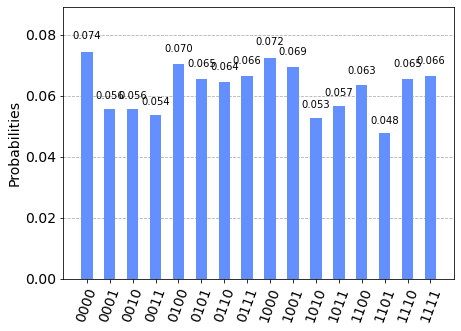

In [10]:
sim_noise = AerSimulator(noise_model=noise_bit_flip)
circ_tnoise = transpile(qc, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = dict.fromkeys(qubit_expansion(NUM_QUBITS), 0)
counts_bit_flip.update(result_bit_flip.get_counts(0))

# Plot noisy output
plot_histogram(counts_bit_flip)

In [11]:
dp_dist = np.array([i[1] for i in sorted(counts_dp.items())]) / sum(counts_dp.values())
dp_noisy_state = Statevector(dp_dist)

bf_dist = np.array([i[1] for i in sorted(counts_bit_flip.items())]) / sum(counts_bit_flip.values())
bf_noisy_state = Statevector(bf_dist)

## Analysis
Take some symmetries from `HQN.ipynb` and analyze the losses under some error.

Classical deep net of circuit depth 1 initialized.
Classical deep net of circuit depth 1 initialized.
4-qubit (noise: 0) non-regularized 'Nelder-Mead' hybrid quantum net initialized -- Hello world!
Classical deep net of circuit depth 1 initialized.
Classical deep net of circuit depth 1 initialized.
4-qubit (noise: 0) non-regularized 'Nelder-Mead' hybrid quantum net initialized -- Hello world!
Classical deep net of circuit depth 1 initialized.
Classical deep net of circuit depth 1 initialized.
4-qubit (noise: 0) non-regularized 'Nelder-Mead' hybrid quantum net initialized -- Hello world!


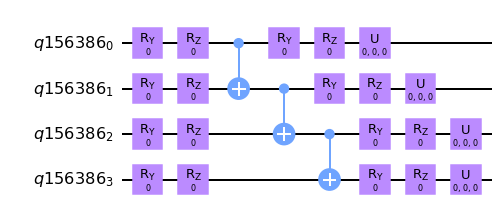

In [20]:
bases = prepare_basis(noiseless_state.num_qubits)
DEPTH = 1
MAXITER = 5E4
num_bases = len(bases)
hqn_noiseless = HQNet(noiseless_state, bases, eta=1e-2, maxiter=MAXITER, disp=False,
            mode='Nelder-Mead', depth=DEPTH, 
            metric_func=KL, regularize=False)
hqn_dp = HQNet(dp_noisy_state, bases, eta=1e-2, maxiter=MAXITER, disp=False,
            mode='Nelder-Mead', depth=DEPTH, 
            metric_func=KL, regularize=False)
hqn_bf = HQNet(bf_noisy_state, bases, eta=1e-2, maxiter=MAXITER, disp=False,
            mode='Nelder-Mead', depth=DEPTH, 
            metric_func=KL, regularize=False)

# Examine the parametrized circuit
hqn_noiseless.view_circuit().draw(output='mpl')

In [21]:
# Find the symmetries of the noiseless and noisy states.
param_shape = (noiseless_state.num_qubits, DEPTH+1, 2)
NRUN = 3
param_dim = np.prod(param_shape)
nets = [hqn_noiseless, hqn_dp, hqn_bf]
proposed_syms = t.zeros((len(nets), NRUN, param_dim)) # first dim is for the 3 types of noise

for i, net in enumerate(nets):
    print(f"\nNet {i+1}:")
    avg = 0
    for j in range(NRUN):
        potential_sym, loss, regularizer_loss = net.find_potential_symmetry(print_log=True)
        proposed_syms[i,j] = potential_sym if t.is_tensor(potential_sym) else t.from_numpy(potential_sym)
        potential_sym = potential_sym.reshape(param_shape)
        avg += loss
    print(f"Average loss for net {i+1}: {avg / NRUN}")
    


Net 1:
Optimized to QKL = 1.3353779345325056e-13
Queried loss func 19551 times
Optimized to QKL = 2.1055324774281112e-14
Queried loss func 8262 times
Optimized to QKL = 5.851016719737867e-12
Queried loss func 14275 times
Average loss for net 1: 2.0018699459884663e-12

Net 2:
Optimized to QKL = 0.0030363104306161404
Queried loss func 9455 times
Optimized to QKL = 0.003664391115307808
Queried loss func 7745 times
Optimized to QKL = 0.006385252811014652
Queried loss func 8518 times
Average loss for net 2: 0.0043619847856462

Net 3:
Optimized to QKL = 0.00041857012547552586
Queried loss func 9421 times
Optimized to QKL = 0.00042632390977814794
Queried loss func 10741 times
Optimized to QKL = 0.0031548854894936085
Queried loss func 9665 times
Average loss for net 3: 0.0013332598415824275


#### Cross validation between noise models
Are symmetries of noisy (noiseless) states still symmetries of noiseless (noisy) states?

In [25]:
print("Key: [state, operator, run, basis]")
for s_i, state in enumerate([noiseless_state, dp_noisy_state, bf_noisy_state]):
    for noise_idx in range(len(nets)):
        if s_i == noise_idx:
            continue # skip diagonal components
        for i, sym in enumerate(proposed_syms[noise_idx]):
            for j, basis_here in enumerate(bases):
                loss_metric = PQC(state, depth=DEPTH, basis_param=basis_here, metric_func=KL, say_hi=False).evaluate_true_metric(sym)
                print(f"[{s_i+1},{noise_idx+1},{i+1},{j+1}] {loss_metric}")

Key: [state, operator, run, basis]
[1,2,1,1] 0.32695991568384974
[1,2,1,2] 0.5906720120485207
[1,2,2,1] 0.08299622787878676
[1,2,2,2] 0.3957283154440946
[1,2,3,1] 0.11688291176649467
[1,2,3,2] 0.4931233578259293
[1,3,1,1] 1.5743334424693458
[1,3,1,2] 1.7927356941711232
[1,3,2,1] 0.477032346673182
[1,3,2,2] 0.6917059331928336
[1,3,3,1] 1.0831125818067844
[1,3,3,2] 0.8396570962838277
[2,1,1,1] 0.22872923992882244
[2,1,1,2] 0.09848787064778221
[2,1,2,1] 0.20298206732675933
[2,1,2,2] 0.2187236991955917
[2,1,3,1] 0.22664245788753692
[2,1,3,2] 0.11112324940557167
[2,3,1,1] 0.003747450417475262
[2,3,1,2] 0.0039092487112393865
[2,3,2,1] 0.0016619369157269293
[2,3,2,2] 0.001622781670165165
[2,3,3,1] 0.004803869373777357
[2,3,3,2] 0.007619538909366022
[3,1,1,1] 0.1705930348984389
[3,1,1,2] 0.10082266511998093
[3,1,2,1] 0.1297222618663766
[3,1,2,2] 0.1617328412352707
[3,1,3,1] 0.2263317803938193
[3,1,3,2] 0.1044906123942559
[3,2,1,1] 0.0031557577949613835
[3,2,1,2] 0.00941457972728406
[3,2,2,1] 0

## Summary
If the noise is sufficiently high (e.g. high noise general bit flip) then the symmetry learning is obviously perturbed. However, for a sufficiently small noise example like the depolarizing noise, the scheme continues to learn the symmetry, at least for small qubit sizes. More tests on larger (`>5`) qubits needed.

We can distinguish between Markovian (unitary-representable) errors and non-Markovian (e.g. measurement, depolarizing) errors. The symmetries of Markovian perturbed states are easily predictable, for they essentially contain the daggers of the unitary representations of the errors. Therefore, we should expect that the scheme work well to find the noisy symmetry, but that it should have a cross validation error roughly proportional to the noise probabilities. On the other hand, non-Markovian perturbed states don't have an easily predictable symmetry, so naively we should expect very poor learning and cross validation. Amazingly, the scheme is learning poorly, but the cross validation error is just as low as if the noise were never there, implying that somehow, the scheme is filtering out the noise while learning non-Markovian symmetries! How it is doing this I have no idea, but this is a key point of discussion.